In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# funtion to split the training dataset into training set and validation set
def train_val_dataset(dataset, data_split=0.25):
    """
    funtion to split the training dataset into training set and validation set
    
    Parameters:
    -----------
    dataset: the dataset to be splited into training set and validation set
    data_split: the training and validation datasets spliting ratio (e.g. data_split=0.25 means 25% of the dataset will become validation set and 75% will become trainng set)
    
    Return:
    -------
    datasets: return the training dataset which contains the training set and validation set
    """
    
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=data_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['valid'] = Subset(dataset, val_idx)
    return datasets

In [4]:
# define the transformations on the training dataset
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.1307),
        std=(0.3081))
])
# transforms.RandomAffine(degrees=(-70, 70), translate=(0.1,0.1), scale=(0.9, 1.1)),   # data transformation
# transforms.RandomAffine(degrees=30, translate=(0.1,0.1), scale=(0.9, 1.1)),   # data transformation

# download the MINST train dataset
dataset = datasets.MNIST(
    root = 'data',
    train = True,
    transform = train_transforms,
    download = True,
)

# call the function train_val_dataset to split the training dataset into training set and validation set
trainvaliddatasets = train_val_dataset(dataset, data_split=0.15)

# define the transformations on the test dataset
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.1307),
        std=(0.3081))
])

# download the MINST test dataset
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = test_transforms,
    download = True,
)

print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.1307, std=0.3081)
           )


In [5]:
from torch.utils.data import DataLoader

batch_size = 100

# create an object named trainLoader of the class DataLoader for train dataset
trainLoader = torch.utils.data.DataLoader(trainvaliddatasets['train'],
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)
print(trainLoader)

# create an object named validLoader of the class DataLoader for validation dataset
validLoader = torch.utils.data.DataLoader(trainvaliddatasets['valid'],
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=1)
print(validLoader)

# create an object named testLoader of the class DataLoader for test dataset
testLoader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=1)
print(testLoader)

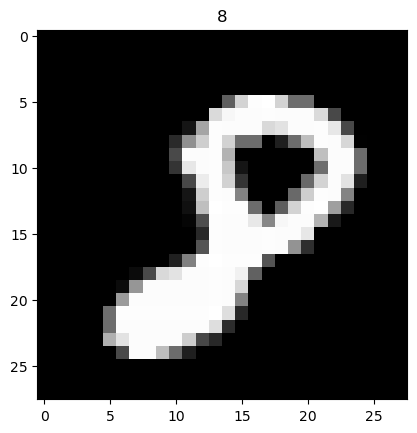

In [6]:
# visualize one single sample data in the MINST dataset

import matplotlib.pyplot as plt

train_batch, trainlabels_batch = next(iter(trainLoader))
#print(train_batch[0][0].shape)
#print(trainlabels_batch.shape)

plt.imshow(train_batch[-1][0], cmap='gray')
plt.title('{}'.format(trainlabels_batch[-1]))
plt.show()

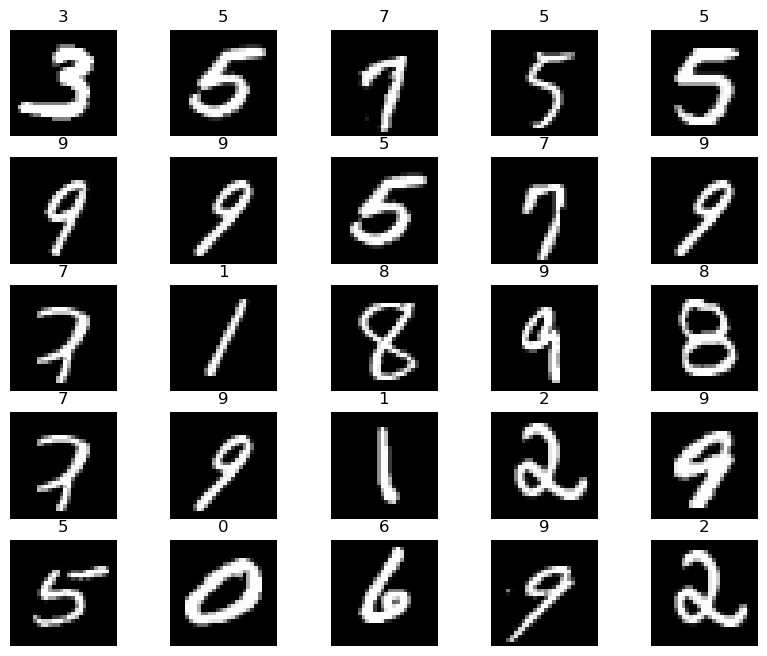

In [7]:
# visualize multiple digits in the MINST dataset

figure  = plt.figure(figsize=(10,8))
cols, rows = 5, 5
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_batch), size=(1,)).item()
    #img, label = train_data[sample_idx]
    img = train_batch[sample_idx][0]
    label = trainlabels_batch[sample_idx].item()
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Convolutional Neural Network model #

In [8]:
import torch.nn as nn

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # first convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=4,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=4,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # third convolution block
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # fully connected layer, output 10 classes
        self.fullnn = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=3*3*64, out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=32, out_features=10),
        )
    
    # define the forward pass / forward propogation function
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        #print("x.size(): ", x.size())
        #print("x.size(0): ", x.size(0))
            
        ### flatten the output of conv3 to (batch_size, 3*3*64)
        x = x.view(x.size(0), -1)   # parameter -1: check https://wandb.ai/ayush-thakur/dl-question-bank/reports/An-Introduction-To-The-PyTorch-View-Function--VmlldzoyMDM0Nzg        
            
        output = self.fullnn(x)
            
        # the x is return for visualization
        return output, x

In [10]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# instantiation of the model object with super class CNN() and then send the model object to GPU
cnn = CNN().to(device=device)
print(cnn)

cuda
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fullnn): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=576, out_features=128, bias=Tr

# Loss Function #

In [11]:
# Define the cost function / loss function
loss_func = nn.CrossEntropyLoss()
loss_func

CrossEntropyLoss()

# Optimization Function #

In [12]:
from torch import optim

# define the optimization function
# optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-4)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

# Train the model #

In [13]:
from tqdm import tqdm

In [14]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

def train(num_epochs, model):
    """
    define a function to train the model
    
    Paramters:
    ----------
    num_epochs: number of epochs, i.e. total number of passes through the whole samples in the trainng and validation datasets
    model: the created neural network
    
    Return:
    -------
    None
    """
    
    #for epoch in tqdm(range(num_epochs)):
    for epoch in range(num_epochs):
        
        model.train()
        
        epoch_train_loss = 0.0
        accuracy_train = 0.0
        
        for i, (images, labels) in enumerate(trainLoader):
            
            train_x = images.to(device=device)
            train_y = labels.to(device=device)
            
            predict_train, last_layer = model(train_x)
            
            # to compute the accuracy of the model on the traning dataset
            pred_train_y = torch.max(predict_train, 1)[1]
            accuracies_train = (pred_train_y == train_y).sum().item() / train_y.size(dim=0)
            accuracy_train += accuracies_train
            
            
            train_loss = loss_func(predict_train, train_y)
            epoch_train_loss += train_loss.item()
            
            
            # clear gradients for this training step
            optimizer.zero_grad()
            
            # backpropagation, compute gradients
            train_loss.backward()
            
            # apply gradients (update the parameters)
            optimizer.step()
        
        train_losses.append(epoch_train_loss/len(trainLoader))
        train_accuracies.append(accuracy_train/len(trainLoader))
        
        model.eval()
        
        epoch_valid_loss = 0.0
        accuracy_valid = 0.0
        
        with torch.no_grad():
            for i, (images, labels) in enumerate(validLoader):
                valid_x = images.to(device=device)
                valid_y = labels.to(device=device)
                
                predict_valid, last_layer = model(valid_x)
                
                # to compute the accuracy of the model on the validation dataset
                pred_valid_y = torch.max(predict_valid, 1)[1]
                accuracies_valid = (pred_valid_y == valid_y).sum().item() / valid_y.size(dim=0)
                accuracy_valid += accuracies_valid
                
                valid_loss = loss_func(predict_valid, valid_y)
                epoch_valid_loss += valid_loss.item()
            
            valid_losses.append(epoch_valid_loss/len(validLoader))
            valid_accuracies.append(accuracy_valid/len(validLoader))
        
        print('epoch [{}/{}] | train loss: {:.4f} | validation loss: {:.4f} | train accuracy: {:.4f}% | validation accuracy: {:.4f}%'.format(epoch+1, num_epochs, epoch_train_loss/len(trainLoader), epoch_valid_loss/len(validLoader), (accuracy_train/len(trainLoader))*100, (accuracy_valid/len(validLoader))*100))

In [15]:
num_epochs = 100   # define the number of epochs

# call the train function to train the model
train(num_epochs, cnn)
#print(train_losses)

epoch [1/100] | train loss: 2.0408 | validation loss: 1.5419 | train accuracy: 28.2392% | validation accuracy: 67.0222%
epoch [2/100] | train loss: 1.4809 | validation loss: 1.0333 | train accuracy: 55.6824% | validation accuracy: 86.3444%
epoch [3/100] | train loss: 1.1132 | validation loss: 0.6545 | train accuracy: 71.5353% | validation accuracy: 93.3889%
epoch [4/100] | train loss: 0.8548 | validation loss: 0.4278 | train accuracy: 79.7490% | validation accuracy: 94.9556%
epoch [5/100] | train loss: 0.6780 | validation loss: 0.2854 | train accuracy: 84.1882% | validation accuracy: 95.7889%
epoch [6/100] | train loss: 0.5669 | validation loss: 0.2070 | train accuracy: 86.4706% | validation accuracy: 96.2889%
epoch [7/100] | train loss: 0.4856 | validation loss: 0.1635 | train accuracy: 88.0922% | validation accuracy: 96.5556%
epoch [8/100] | train loss: 0.4319 | validation loss: 0.1338 | train accuracy: 89.2314% | validation accuracy: 96.9111%
epoch [9/100] | train loss: 0.3889 | val

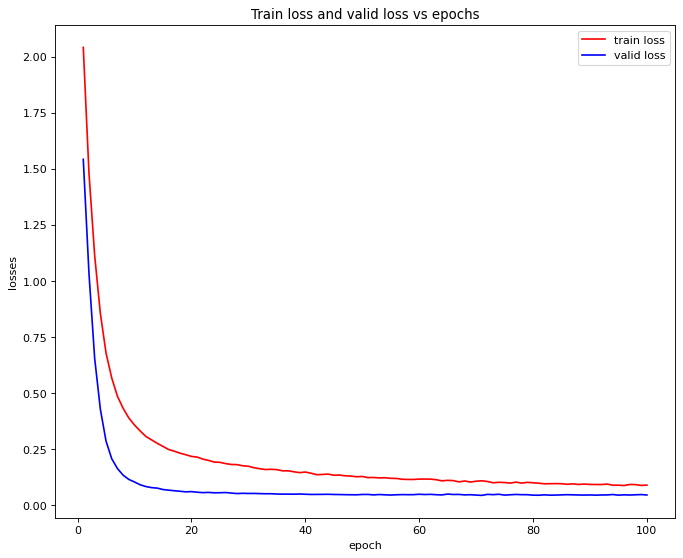

In [16]:
# plot the training and validation losses versus epochs

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)

epochs_range = np.arange(1,num_epochs+1)

# plotting
plt.title("Train loss and valid loss vs epochs")
plt.xlabel("epoch")
plt.ylabel("losses")

plt.plot(epochs_range, train_losses, color ="red")
plt.plot(epochs_range, valid_losses, color ="blue")
plt.legend(['train loss', 'valid loss'], loc='best')
plt.show()

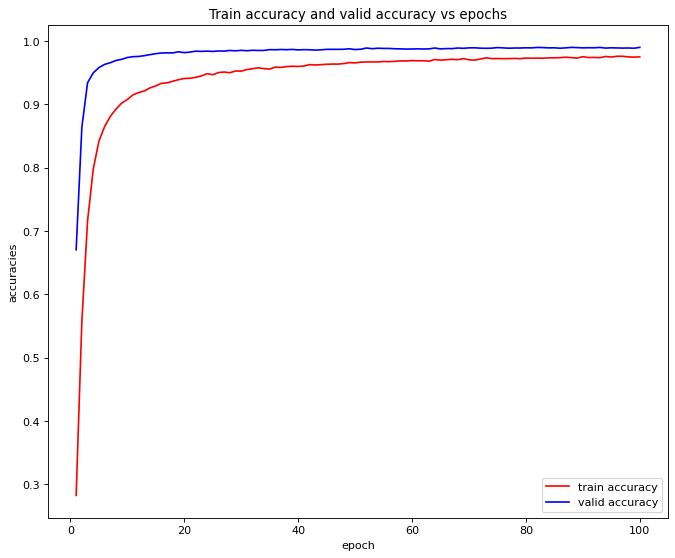

In [17]:
# plot the accuracies on the training and validation datasets versus epochs

figure(figsize=(10, 8), dpi=80)

epochs_range = np.arange(1,num_epochs+1)

# plotting
plt.title("Train accuracy and valid accuracy vs epochs")
plt.xlabel("epoch")
plt.ylabel("accuracies")

plt.plot(epochs_range, train_accuracies, color ="red")
plt.plot(epochs_range, valid_accuracies, color ="blue")
plt.legend(['train accuracy', 'valid accuracy'], loc='best')
plt.show()

# Test the model #

In [18]:
accuracy_list = []

# function of computing the accuracy of the model on all the test images
def test(model, loader):
    """
    function of computing the accuracy of the model on all the test images
    
    Paramters:
    ----------
    model: neural network model
    loader: dataloader object to load the test dataset
    
    Return:
    -------
    None
    """
    # test the model
    model.eval()
    
    with torch.no_grad():
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(testLoader):
            images = images.to(device=device)
            labels = labels.to(device=device)
            test_output, last_layer = model(images)
            
            pred_y = torch.max(test_output, 1)[1]
            
            accuracy = (pred_y == labels).sum().item() / labels.size(dim=0)
            
            accuracy_list.append(accuracy)

In [19]:
test(cnn, testLoader)

# print(accuracy_list)

accuracy = sum(accuracy_list) / len(accuracy_list)

print("The accuracy of the model on all test images is {:.2f}%.".format(accuracy*100))

The accuracy of the model on all test images is 99.11%.
